<a href="https://colab.research.google.com/github/sameer91/8th_sem/blob/master/kaggle_tumor_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
cp /content/drive/My\ Drive/brain_dataset/brain-mri-images-for-brain-tumor-detection.zip brain.zip

In [0]:
!unzip -q brain.zip

In [3]:
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import imutils
import itertools
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

init_notebook_mode(connected = True)

RANDOM_SEED = 123

Using TensorFlow backend.


In [0]:
!mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO

Split into *train*, *val*  and *test*


In [0]:
IMG_PATH = './brain_tumor_dataset/'

#split
for CLASS in os.listdir(IMG_PATH):
  if not CLASS.startswith('.'):
    IMG_NUM = len(os.listdir(IMG_PATH+CLASS))
    for (n, FILE_NAME ) in enumerate(os.listdir(IMG_PATH + CLASS)):
      img = IMG_PATH + CLASS + '/' + FILE_NAME
      if n < 5:
        shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
      elif n < 0.8*IMG_NUM:
        shutil.copy(img, 'TRAIN/' + CLASS.upper() + '/' + FILE_NAME)
      else:
        shutil.copy(img, 'VAL/' + CLASS.upper() + '/' + FILE_NAME)

In [0]:
#!zip -r dataset_split.zip TEST TRAIN VAL

DATA IMPORT & PREPROCESS

In [29]:
def load_data(dir_path, img_size=(124,124)):
  #Load resized images as np.array
  X = []
  y = []
  i = 0
  labels = dict()
  for path in tqdm(sorted(os.listdir(dir_path))):
    if not path.startswith('.'):
      labels[i] = path
      for file in os.listdir(dir_path + path):
        if not file.startswith('.'):
          img = cv2.imread(dir_path + path + '/' + file) #pass zero for greyscale
          X.append(img)
          y.append(i)
      i += 1
  X = np.array(X)
  y = np.array(y)
  print(f'{len(X)} images loaded fomr {dir_path} directory.')
  return X, y, labels

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  plt.figure(figsize=(6,6))
  plt.imshow(cm,interpolation='nearest',cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=90)
  plt.yticks(tick_marks, classes)
  if normalize:
    cm = cm.astype('float') /cm.sum(axis=1) [:, np.newaxis]
  thresh = cm.max() / 2 
  cm = np.round(cm,2)
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j,i,cm[i,j],
             horizontalalignment="center",
             color="white" if cm[i,j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show

TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)


100%|██████████| 2/2 [00:00<00:00, 18.58it/s]

193 images loaded fomr TRAIN/ directory.
10 images loaded fomr TEST/ directory.
50 images loaded fomr VAL/ directory.


Plot 30 imgs


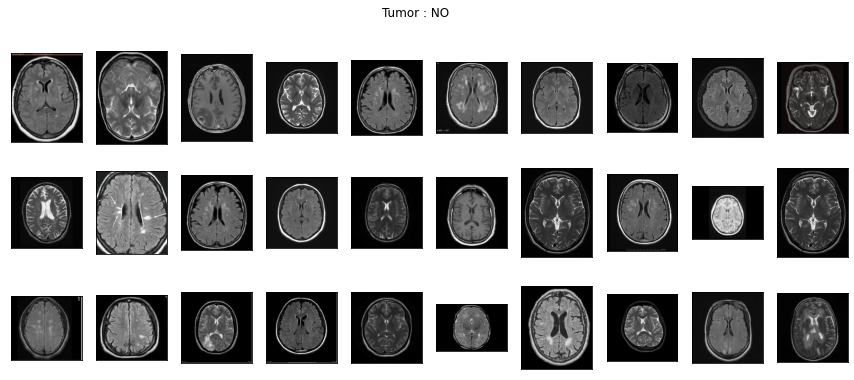

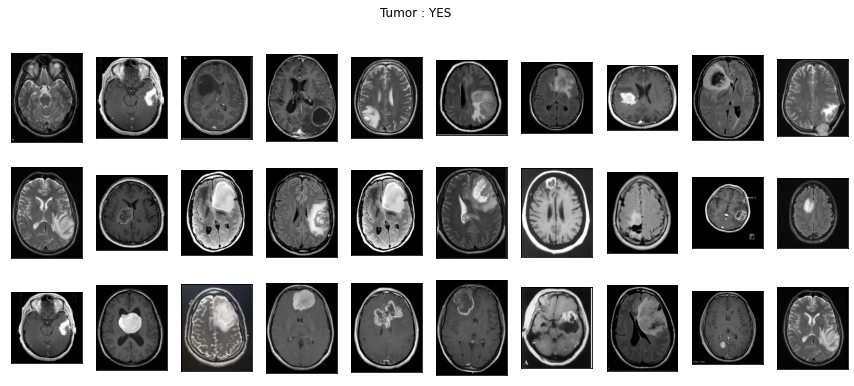

In [7]:
for index in range(len(labels)):
  imgs = X_train[np.argwhere(y_train == index)] [:30]

  plt.figure(figsize=(15,6))
  c = 1
  for img in imgs:
    plt.subplot(3,10,c)
    plt.imshow(img[0])
    plt.xticks([])
    plt.yticks([])
    c += 1
  plt.suptitle(f'Tumor : {labels[index]}')
  plt.show()

Crop brain part out of IMAGE
[blog](https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/)

In [0]:
def crop_imgs(set_name, add_pixel_values=0):
  #find extreme points
  set_new = []
  for img in set_name:
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #gray = img
    gray = cv2.GaussianBlur(gray, (5,5), 0)
    #remove noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY) [1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    #find the largest contours
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
  
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    ADD_PIXEL = add_pixel_values
    new_img = img[extTop[1]-ADD_PIXEL:extBot[1]+ADD_PIXEL, extLeft[0]-ADD_PIXEL:extRight[0]+ADD_PIXEL].copy()
    set_new.append(new_img)
  
  return np.array(set_new)

In [0]:
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

Plot cropped

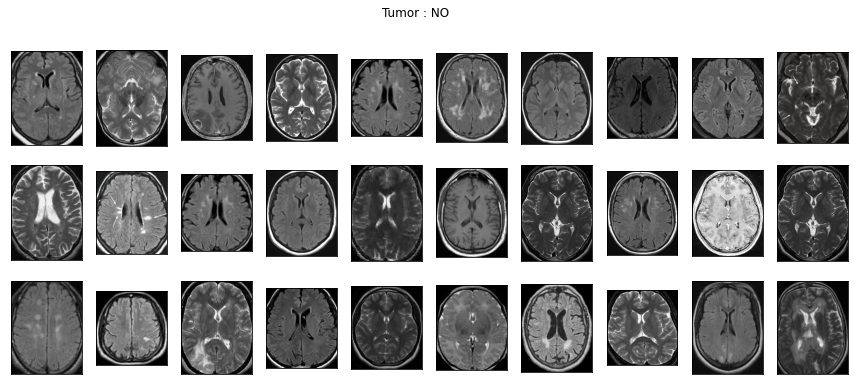

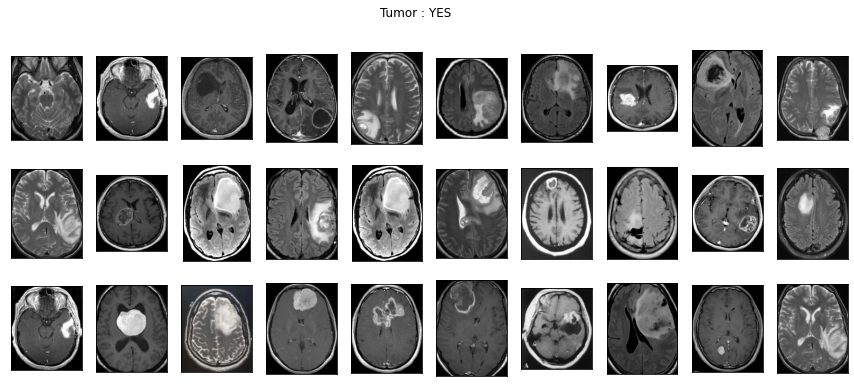

In [10]:
for index in range(len(labels)):
  imgs = X_train_crop[np.argwhere(y_train == index)] [:30]

  plt.figure(figsize=(15,6))
  c = 1
  for img in imgs:
    plt.subplot(3,10,c)
    plt.imshow(img[0])
    plt.xticks([])
    plt.yticks([])
    c += 1
  plt.suptitle(f'Tumor : {labels[index]}')
  plt.show()

In [0]:
!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/YES TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES VAL_CROP/NO

In [0]:
def save_new_img(x_set, y_set, folder_name):
  i = 0
  for (img, imclass) in zip(x_set, y_set):
    if imclass == 0:
      cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
    else:
      cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
    i += 1

In [0]:
save_new_img(X_train_crop, y_train, 'TRAIN_CROP/')
save_new_img(X_test_crop, y_test, 'TEST_CROP/')
save_new_img(X_val_crop, y_val, 'VAL_CROP/')

In [0]:
def preprocess_img(set_name, img_size):
  set_new = []
  for img in set_name:
    img = cv2.resize(img, dsize = img_size,
                     interpolation=cv2.INTER_CUBIC
                     )
    set_new.append(preprocess_input(img))
  return np.array(set_new)

In [0]:
X_train_prep = preprocess_img(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_img(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_img(set_name=X_val_crop, img_size=IMG_SIZE)

In [0]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'

train_datagen = ImageDataGenerator(
    rotation_range = 15,
    width_shift_range = 0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5,0.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [17]:

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 193 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [18]:
# load base model
base_model = VGG16(
    weights='imagenet',
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

58892288/58889256 [==============================] - 3s 0us/step


In [19]:
NUM_CLASSES = 1

model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25089     
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


In [21]:
EPOCHS = 30
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=6
)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=50,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[es]
)

Epoch 1/30
50/50 [==============================] - 23s 456ms/step - loss: 1.5522 - accuracy: 0.7599 - val_loss: 0.1644 - val_accuracy: 0.8639
Epoch 2/30
50/50 [==============================] - 21s 419ms/step - loss: 1.4634 - accuracy: 0.7693 - val_loss: 0.0155 - val_accuracy: 0.8956
Epoch 3/30
50/50 [==============================] - 21s 424ms/step - loss: 1.1916 - accuracy: 0.8098 - val_loss: 0.2609 - val_accuracy: 0.8987
Epoch 4/30
50/50 [==============================] - 21s 417ms/step - loss: 1.8955 - accuracy: 0.8171 - val_loss: 4.0135e-16 - val_accuracy: 0.9007
Epoch 5/30
50/50 [==============================] - 21s 417ms/step - loss: 1.2416 - accuracy: 0.8417 - val_loss: 0.3591 - val_accuracy: 0.9399
Epoch 6/30
50/50 [==============================] - 21s 422ms/step - loss: 0.8181 - accuracy: 0.8539 - val_loss: 0.0914 - val_accuracy: 0.9652
Epoch 7/30
50/50 [==============================] - 22s 433ms/step - loss: 0.8948 - accuracy: 0.8510 - val_loss: 0.1437 - val_accuracy: 0.

Performance

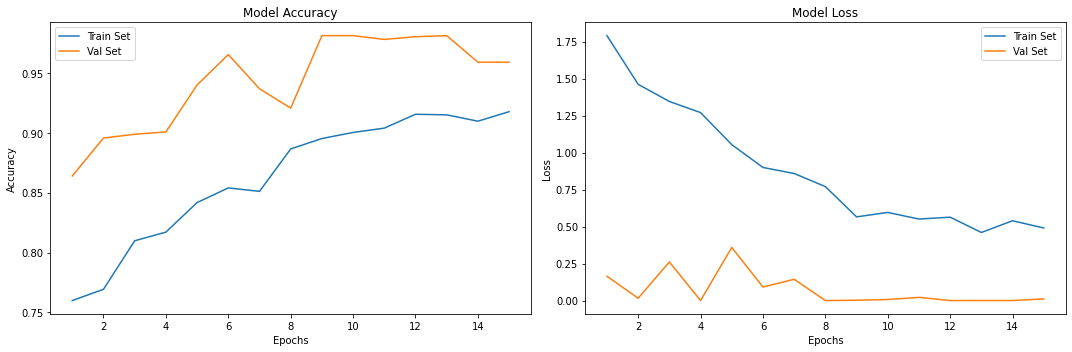

In [25]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

Val Accuracy = 0.96


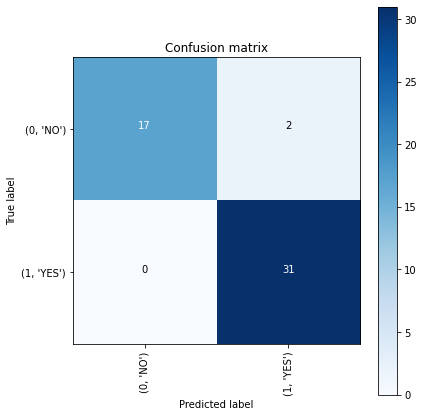

In [30]:
# validate on val set
predictions = model.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

Test Accuracy = 0.80


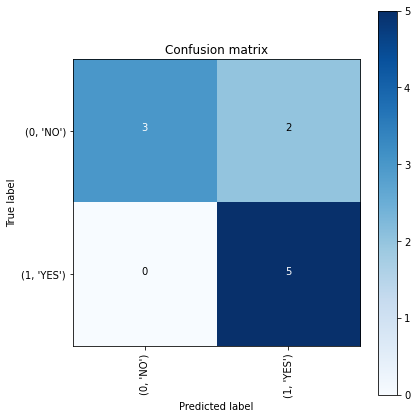

In [31]:
# validate on test set
predictions = model.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)